# Evolutionary Computation - Assignment 6 Report

* Kajetan Sulwiński 151954
* Mikołaj Marmurowicz 151956

## Imports

In [16]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib import MatplotlibDeprecationWarning
import warnings

## Problem instance reading and cost scaling

In [17]:
dfTSPA = pd.read_csv('.\\TSPA.csv', sep=';', names=['X', 'Y', 'Cost'])
dfTSPB = pd.read_csv('.\\TSPB.csv', sep=';', names=['X', 'Y', 'Cost'])

min_cost_A = dfTSPA['Cost'].min()
max_cost_A = dfTSPA['Cost'].max()
dfTSPA['Normalized_Cost'] = (dfTSPA['Cost'] - min_cost_A) / (max_cost_A - min_cost_A)

min_cost_B = dfTSPB['Cost'].min()
max_cost_B = dfTSPB['Cost'].max()
dfTSPB['Normalized_Cost'] = (dfTSPB['Cost'] - min_cost_B) / (max_cost_B - min_cost_B)

## Problem description

### Problem

We were to find a cycle that consisted of exactly 50% of the available nodes, where each node had its own cost along with x and y coordinates. The objective function was a sum of node costs and distances (Euclidean) between each traveled node. 

### Solution implementation

We have added two new methods of LS - Multiple start local search and Iterated local search.

* **Multiple start local search**

    * **Input:**
        - `nodes` : An array of available nodes
        - `costDistanceInfo` : A symmetric matrix of distances and costs between nodes
        - `iterations` : A number of iterations that the algorithm is to be run

    * **Output:**
        - An array of new `cycle` node IDs

    * **Function:**

        ```python
        FUNCTION generateCycle(start_pos)
            INITIALIZE bestCycle AS an empty array
            INITIALIZE bestFuncValue TO -1
            # Create an initial cycle generator
            INITIALIZE initialGenerator AS RandomHamiltonianCycleGenerator(costDistanceInfo, nodesInCycle, start_pos * iters)
            FOR i FROM 0 TO iters - 1 DO
                # Generate an initial cycle
                INITIALIZE cycle AS initialGenerator.generateCycle(i)
                # Perform local search optimization on the cycle
                INITIALIZE localSearchGenerator AS LocalSearchGenerator(costDistanceInfo, cycle)
                INITIALIZE optimizedCycle AS localSearchGenerator.generateCycle(i)
                # Calculate the objective value of the optimized cycle
                INITIALIZE currFuncValue AS localSearchGenerator.calculateCycleCost(optimizedCycle)
                # Update the best cycle if a better one is found
                IF currFuncValue < bestFuncValue OR bestFuncValue == -1 THEN
                    SET bestFuncValue TO currFuncValue
                    SET bestCycle TO optimizedCycle
                END IF
            END FOR
            RETURN bestCycle
        END FUNCTION
        ```


* **Iterated local search**

    * **Input:**
        - `nodes` : An array of available nodes
        - `costDistanceInfo` : A symmetric matrix of distances and costs between nodes
        - `time` : A duration for which the algorithm is to be run
        - `perturbation_moves` : A number of perturbation moves to be performed between iterations

    * **Output:**
        - An array of new `cycle` node IDs

    * **Function:**

        ```python
        FUNCTION generateCycle(start_pos)
            # Generate an initial random cycle
            GENERATE currentCycle BY RandomHamiltonianCycle
            # Perform local search on the initial cycle
            INITIALIZE localSearchGenerator AS LocalSearchGenerator(costDistanceInfo, currentCycle)
            SET currentCycle TO localSearchGenerator.generateCycle(start_pos)
            INITIALIZE bestFuncValue AS localSearchGenerator.calculateCycleCost(currentCycle)
            INITIALIZE bestCycle AS currentCycle
            INITIALIZE startTime AS current time
            INITIALIZE currTime AS current time
            CALCULATE timePassed AS currTime - startTime
            WHILE timePassed < maxRuntime DO
                # Apply perturbation to the current cycle
                CALL perturbCycle(currentCycle)
                # Perform local search on the perturbed cycle
                INITIALIZE localSearchGeneratorCur AS LocalSearchGenerator(costDistanceInfo, currentCycle)
                SET currentCycle TO localSearchGeneratorCur.generateCycle(start_pos)
                INITIALIZE currFuncValue AS localSearchGeneratorCur.calculateCycleCost(currentCycle)
                # Update the best cycle if a better one is found
                IF currFuncValue < bestFuncValue THEN
                    SET bestCycle TO currentCycle
                    SET bestFuncValue TO currFuncValue
                ELSE
                    # Revert to the best cycle if no improvement
                    SET currentCycle TO bestCycle
                END IF
                # Update time and iteration count
                SET currTime TO current time
                CALCULATE timePassed AS currTime - startTime
                INCREMENT iterationsDone
            END WHILE
            RETURN bestCycle
        END FUNCTION
        ```

        ```python
        FUNCTION perturbCycle(currentCycle)
            # Apply perturbations
            FOR i FROM 0 TO perturbationMoves - 1 DO
                # Determine move type (inter or intra)
                INITIALIZE isInterMove AS moveType(rng) == 0
                IF isInterMove THEN
                    GENERATE ALL POSSIBLE interMoves
                    INITIALIZE move AS RANDOM CHOICE FROM interMoves
                    CALL move.performMove(currentCycle, NULL)
                ELSE
                    GENERATE ALL POSSIBLE intraMoves
                    INITIALIZE move as RANDOM CHOICE FROM intraMoves
                    CALL Move.performMove(currentCycle, NULL)
                END IF
            END FOR
        END FUNCTION
        ```

## Presenting the results

### Results presented as minimum, average and maximum of objective function

Presented in a table below, each method and each problem instance is shown.

In [18]:
file_paths = ['.\\TSPA_IteratedLocalSearch.csv', '.\\TSPA_MultistartLocalSearch.csv',
              '.\\TSPB_IteratedLocalSearch.csv', '.\\TSPB_MultistartLocalSearch.csv'] 
methods = ['Iterated LS', 'Multiple start LS']
results = []
best_solutions = []
counter = 0
for file_path, method in zip(file_paths, methods * 2):
    df = pd.read_csv(file_path)
    costs = df.iloc[:, -1]
    minimum = costs.min()
    maximum = costs.max()
    mean = round(costs.mean(), 2)
    if counter < len(methods):
        results.append((method, 'TSPA', f"{mean} ({minimum} - {maximum})"))
    else:
        results.append((method, 'TSPB', f"{mean} ({minimum} - {maximum})"))
    if '..' not in file_path:
        min_sol = df.loc[costs.idxmin()][:-1].to_list()
        best_solutions.append(min_sol)
    counter += 1
result_df = pd.DataFrame(results, columns=['Method', 'Column', 'Value'])
result_df = result_df.pivot(index='Method', columns='Column', values='Value')
result_df.columns.name = None
result_df

,TSPA,TSPB
Method,,
Iterated LS,69256.11 (69095 - 69614),43634.53 (43448 - 44215)
Multiple start LS,71250.74 (70684 - 71957),45795.84 (45108 - 46295)


Information regarding running time of Multiple start LS and number of local searches in Iterated LS.

In [19]:
times_files = ['.\\times.csv', '.\\ILSruns.csv']

results_times = []
for counter_main, file in enumerate(times_files):
    df_temp = pd.read_csv(file, header=None).iloc[:, :-1]
    for count, column in enumerate(df_temp.columns):
        min_value = df_temp[column].min()
        max_value = df_temp[column].max()
        avg_value = df_temp[column].mean()
        if counter_main < 1:
            if count < 1:
                results_times.append(('Multiple start LS', 'TSPA', f"{round(avg_value, 4)} ({round(min_value, 4)} - {round(max_value, 4)}) ms"))
            else:
                results_times.append(('Multiple start LS', 'TSPB', f"{round(avg_value, 4)} ({round(min_value, 4)} - {round(max_value, 4)}) ms"))
        else:
            if count < 1:
                results_times.append(('Iterated LS', 'TSPA', f"{round(avg_value, 4)} ({round(min_value, 4)} - {round(max_value, 4)}) runs"))
            else:
                results_times.append(('Iterated LS', 'TSPB', f"{round(avg_value, 4)} ({round(min_value, 4)} - {round(max_value, 4)}) runs"))

times_df = pd.DataFrame(results_times, columns=['Method', 'Column', 'Value'])
times_df = times_df.pivot(index='Method', columns='Column', values='Value')
times_df.columns.name = None  
times_df

,TSPA,TSPB
Method,,
Iterated LS,2602.95 (2358 - 2823) runs,2611.65 (2416 - 2886) runs
Multiple start LS,36404.82 (33524.3 - 38601.8) ms,34441.575 (33030.7 - 38215.2) ms


### Visualization of the best path for each method

Additionally, a list of node indices is presented.

Iterated LS
TSPA
[80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 108, 18, 69, 68, 46, 115, 139, 41, 193, 159, 22, 146, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 35, 184, 42, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 196, 81, 90, 165, 119, 40, 185, 179, 92, 129, 57, 55, 52, 106, 178, 49, 14, 144, 102, 62, 9, 148, 124, 94, 63, 79]
0 2
TSPB
[139, 168, 195, 13, 145, 15, 3, 70, 132, 169, 188, 6, 147, 90, 51, 121, 131, 135, 122, 133, 107, 40, 63, 38, 27, 16, 1, 156, 198, 117, 193, 31, 54, 73, 136, 190, 80, 45, 142, 175, 78, 5, 177, 36, 61, 91, 141, 77, 81, 153, 187, 163, 103, 89, 127, 137, 114, 113, 176, 194, 166, 86, 185, 95, 130, 99, 22, 179, 66, 94, 47, 148, 60, 20, 28, 149, 4, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 143, 35, 109, 0, 29, 111, 8, 104, 144, 160, 33, 138, 11]


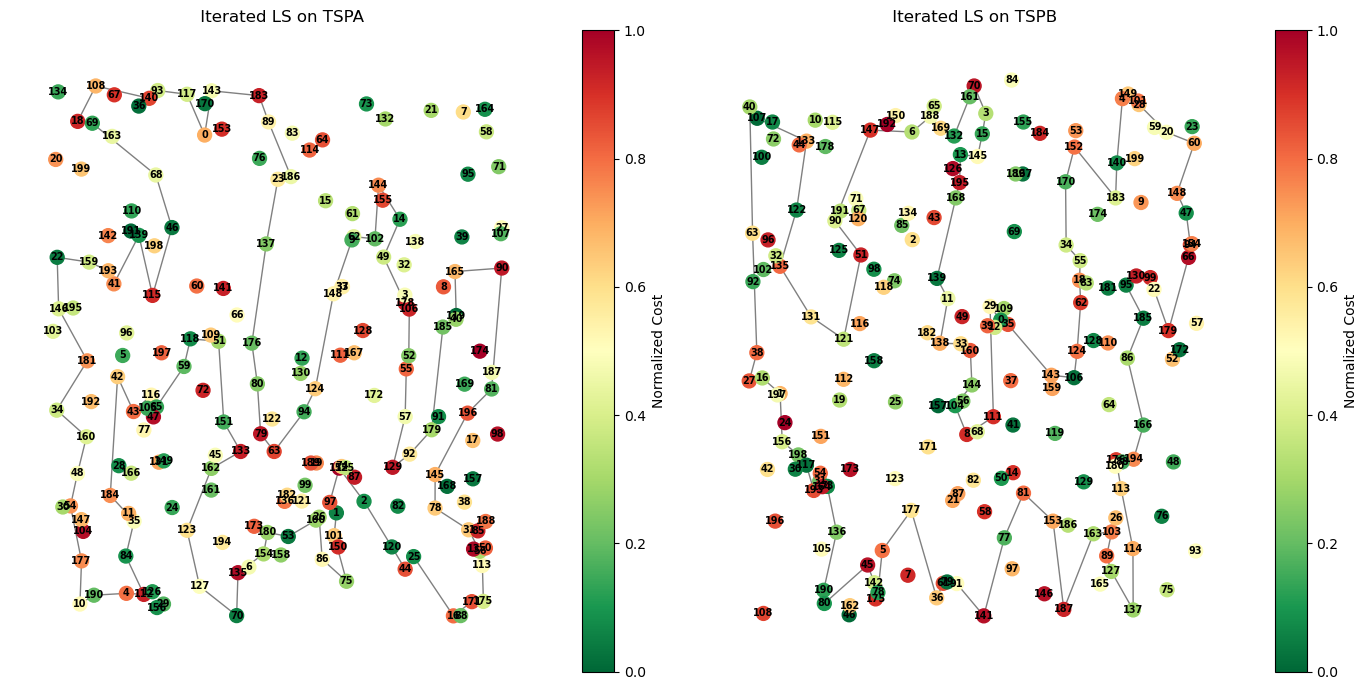

Multiple start LS
TSPA
[101, 1, 97, 152, 124, 94, 121, 53, 158, 180, 154, 135, 70, 127, 123, 162, 151, 133, 79, 63, 80, 176, 51, 118, 59, 65, 116, 43, 184, 35, 84, 112, 4, 10, 177, 54, 160, 42, 181, 34, 146, 22, 159, 193, 41, 115, 139, 69, 18, 108, 140, 93, 68, 46, 0, 117, 143, 183, 89, 186, 23, 137, 148, 9, 62, 144, 102, 49, 14, 3, 178, 106, 52, 55, 57, 129, 92, 78, 145, 179, 185, 40, 119, 165, 90, 81, 31, 56, 113, 175, 171, 16, 25, 44, 120, 2, 75, 86, 100, 26]
1 3
TSPB
[113, 180, 176, 194, 166, 86, 185, 99, 22, 179, 66, 94, 47, 148, 60, 20, 28, 149, 140, 183, 95, 128, 106, 124, 62, 18, 55, 34, 170, 152, 184, 155, 3, 70, 15, 145, 29, 0, 109, 35, 111, 8, 104, 144, 160, 33, 138, 11, 139, 168, 195, 13, 132, 169, 188, 6, 147, 90, 51, 121, 131, 122, 107, 40, 63, 135, 38, 27, 1, 198, 117, 54, 73, 31, 193, 190, 80, 175, 78, 142, 5, 177, 21, 87, 82, 61, 36, 91, 141, 77, 153, 187, 163, 26, 103, 89, 165, 127, 137, 114]


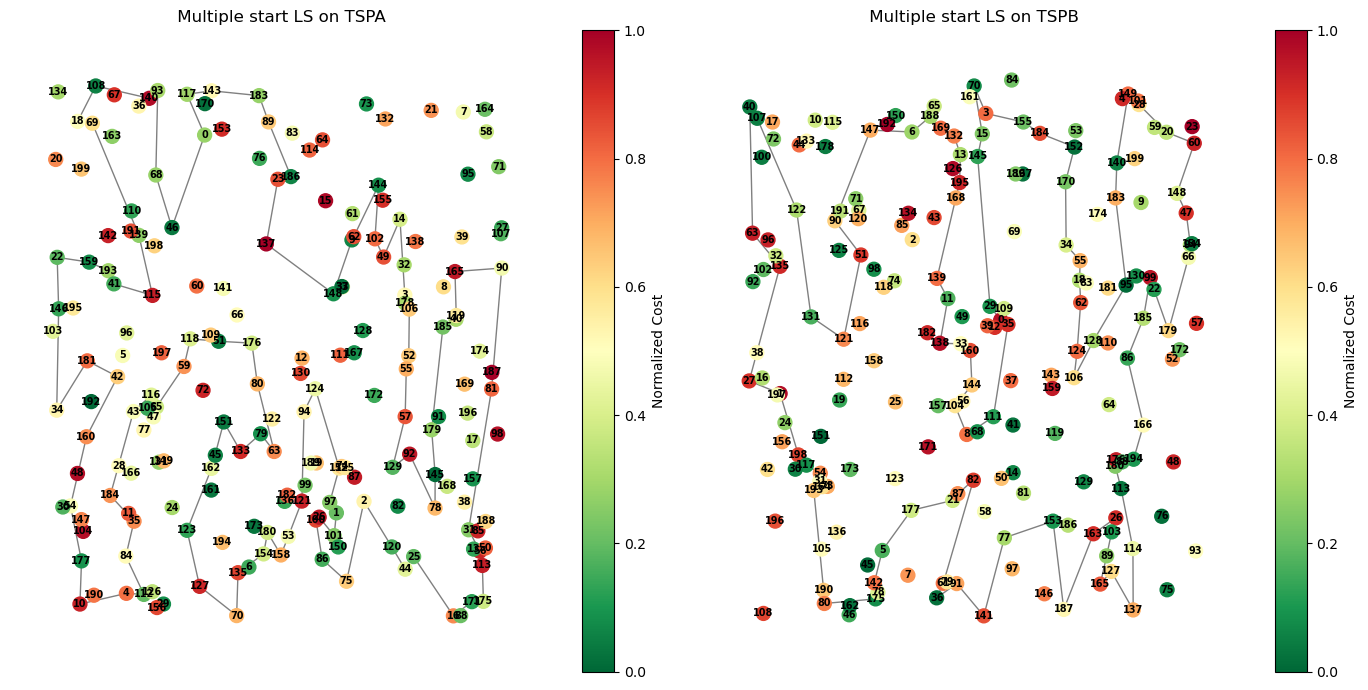

In [20]:
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
cmap = plt.cm.get_cmap('RdYlGn_r')

for count, method in enumerate(methods):
    if count == len(best_solutions) // 2:
        break
    print(method)
    print('TSPA')
    print(best_solutions[count])
    print(count, count + len(best_solutions)//2)
    print('TSPB')
    print(best_solutions[count + len(best_solutions)//2])

    fig, axs = plt.subplots(1, 2, figsize=(14, 7))

    for count, sol in enumerate([best_solutions[count], best_solutions[count + len(best_solutions)//2]]):
        if count == 0:
            df_temp = dfTSPA
            ax = axs[0]
            instance = 'TSPA'
        else:
            df_temp = dfTSPB
            ax = axs[1]
            instance = 'TSPB'

        G = nx.Graph()
        positions = {}

        for idx in sol:
            G.add_node(idx, size=df_temp.loc[idx, 'Normalized_Cost'])
            positions[idx] = (df_temp.loc[idx, 'X'], df_temp.loc[idx, 'Y'])

        for idx in [i for i in range(0,200) if i not in sol]:
            G.add_node(idx, size=df_temp.loc[idx, 'Normalized_Cost'])
            positions[idx] = (df_temp.loc[idx, 'X'], df_temp.loc[idx, 'Y'])

        for i in range(len(sol) - 1):
            G.add_edge(sol[i], sol[i + 1])
        G.add_edge(sol[-1], sol[0])


        normalized_costs = df_temp['Normalized_Cost']
        norm = mcolors.Normalize(vmin=normalized_costs.min(), vmax=normalized_costs.max())
        node_colors = [cmap(norm(df_temp.loc[idx, 'Normalized_Cost'])) for idx in range(0, 200)]

        nx.draw(G, pos=positions, with_labels=True, node_color=node_colors, node_size=100,
            font_size=7, edge_color='gray', linewidths=1, font_weight='bold', ax=ax)

        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Normalized Cost')

        ax.set_title(f" {method} on {instance}")

    plt.tight_layout()
    plt.show()

## Additional Information

### Solution checker

We have checked all of the best solutions via the solution checker provided.

### Source code link

The source code is available in a repository [here](https://github.com/Mickeyo0o/EvolutionaryComp/tree/main/Lab6) under the Lab6 folder.

## Conclusions

Multiple Start Local Search allows exploration of the solution space but lacks the ability to refine solutions further, leading to worse results in both problem instances. In contrast, Iterated Local Search balances exploration with refinement of the current solution, enabling it to achieve higher-quality results.

Interestingly, while Multiple Start Local Search took the same amount of time to perform 200 iterations of Local Search, Iterated Local Search managed to complete 13x as many iterations. This is because Multiple Start Local Search performs Local Search from a newly generated random solution in each iteration, which often requires significant changes to reach a local optimum. Conversely, Iterated Local Search begins each iteration (after the first) with a solution from the previous iteration, perturbed only slightly, thereby requiring far fewer changes and allowing for much faster iterations.

## Authors

* Kajetan Sulwiński 151954
* Mikołaj Marmurowicz 151956